# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

In [2]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
from sagemaker.session import Session
from sagemaker import get_execution_role
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner, IntegerParameter
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.predictor import Predictor
from sagemaker.debugger import Rule, rule_configs, ProfilerRule, DebuggerHookConfig, CollectionConfig, ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

role = get_execution_role()
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
print(f'Execition Role: {role}')
print(f'Default s3 bucket : {bucket}')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
[2024-09-29 18:05:53.016 default:17227 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
Execition Role: arn:aws:iam::730965006182:role/service-role/AmazonSageMaker-ExecutionRole-20240829T030434
Default s3 bucket : sagemaker-us-east-1-730965006182


## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [ ]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget --no-check-certificate https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip > /dev/null

--2024-09-29 17:35:04--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.48, 52.219.113.8, 52.219.221.16, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.48|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip.1’

dogImages.zip.1      17%[==>                 ] 187.17M  14.9MB/s    eta 68s    ^C
replace dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
inputs = sagemaker_session.upload_data(path="dogImages", bucket=bucket, key_prefix='imagesDogClassesSet')
print(f'Input path (S3 file path): {inputs}')

Input path (S3 file path): s3://sagemaker-us-east-1-730965006182/imagesDogClassesSet


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [6]:
inputs = "s3://sagemaker-us-east-1-730965006182/imagesDogClassesSet"

In [7]:
# TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    'lr': ContinuousParameter(0.001, 0.1),
    'batch_size': CategoricalParameter([16, 32, 64]),
    'epochs': IntegerParameter(2, 6)
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [8]:
#TODO: Create estimators for your HPs

estimator = PyTorch(entry_point = 'hpo.py',
                                    base_job_name = 'dog-breed-classification-hpo',
                                    role = role,
                                    instance_count = 1,
                                    instance_type = 'ml.m5.2xlarge', 
                                    py_version = 'py36',
                                    framework_version = '1.8')

tuner = HyperparameterTuner(estimator,
                             objective_metric_name,
                             hyperparameter_ranges,
                             metric_definitions,
                             max_jobs = 4,
                             max_parallel_jobs = 1,
                             objective_type = objective_type)

In [9]:
# TODO: Fit your HP Tuner
tuner.fit({'train': inputs}, wait=True) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


.......................................................................................................................................................................!


In [10]:
tuner.describe()

{'HyperParameterTuningJobName': 'pytorch-training-240929-1807',
 'HyperParameterTuningJobArn': 'arn:aws:sagemaker:us-east-1:730965006182:hyper-parameter-tuning-job/pytorch-training-240929-1807',
 'HyperParameterTuningJobConfig': {'Strategy': 'Bayesian',
  'HyperParameterTuningJobObjective': {'Type': 'Minimize',
   'MetricName': 'average test loss'},
  'ResourceLimits': {'MaxNumberOfTrainingJobs': 4,
   'MaxParallelTrainingJobs': 1},
  'ParameterRanges': {'IntegerParameterRanges': [{'Name': 'epochs',
     'MinValue': '2',
     'MaxValue': '6',
     'ScalingType': 'Auto'}],
   'ContinuousParameterRanges': [{'Name': 'lr',
     'MinValue': '0.001',
     'MaxValue': '0.1',
     'ScalingType': 'Auto'}],
   'CategoricalParameterRanges': [{'Name': 'batch_size',
     'Values': ['"16"', '"32"', '"64"']}]},
  'TrainingJobEarlyStoppingType': 'Off'},
 'TrainingJobDefinition': {'StaticHyperParameters': {'_tuning_objective_metric': 'average test loss',
   'sagemaker_container_log_level': '20',
   'sa

In [11]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator() #TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2024-09-29 18:12:28 Starting - Preparing the instances for training
2024-09-29 18:12:28 Downloading - Downloading the training image
2024-09-29 18:12:28 Training - Training image download completed. Training in progress.
2024-09-29 18:12:28 Uploading - Uploading generated training model
2024-09-29 18:12:28 Completed - Resource reused by training job: pytorch-training-240929-1807-002-7ec9fd30


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"64"',
 'epochs': '2',
 'lr': '0.0047518352618877565',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"dog-breed-classification-hpo-2024-09-29-18-06-59-719"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-730965006182/dog-breed-classification-hpo-2024-09-29-18-06-59-719/source/sourcedir.tar.gz"'}

In [12]:
best_hyperparameters = {'batch_size': 64,
                        'epochs': 2,
                        'lr': 0.0047518352618877565
                        }

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [13]:
# TODO: Set up debugging and profiling rules and hooks

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(system_monitor_interval_millis=500, 
                                                       framework_profile_params = FrameworkProfile(num_steps=10))

collection_config = [CollectionConfig(name="CrossEntropyLoss_output_0", 
                                    parameters={"include_regex": "CrossEntropyLoss_output_0",
                                                            "train.save_interval": "10",
                                                            "eval.save_interval": "1"})]

debugger_config = DebuggerHookConfig(collection_configs = collection_config)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [14]:
# TODO: Create and fit an estimator

# TODO: Your estimator here
estimator = PyTorch(entry_point = 'train_model.py',
                                    role = role,
                                    instance_count=1,
                                    instance_type = 'ml.m5.2xlarge',
                                    py_version = 'py36',
                                    framework_version = '1.6',
                                    hyperparameters = best_hyperparameters,
                                    profiler_config = profiler_config, 
                                    debugger_hook_config = debugger_config, 
                                    rules = rules ) 


In [15]:
# TODO: Plot a debugging output.
estimator.fit({'train':inputs}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2024-09-29-18-25-40-781


2024-09-29 18:25:43 Starting - Starting the training job...
2024-09-29 18:26:08 Starting - Preparing the instances for trainingVanishingGradient: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
...
2024-09-29 18:26:44 Downloading - Downloading input data......
2024-09-29 18:27:45 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-09-29 18:27:43,873 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-09-29 18:27:43,876 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-09-29 18:27:43,886 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-09-29 18:27:43,889 sagemaker_pytorch_container.training INFO     Invoking user training script.
2024-09-29 18:27:44,090 sagemaker-training-toolkit INFO     No GPUs detected

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  

There is no error, but a warning that the weight initialization is poor. There is no need to fix it as it would not matter with gradient descent. The trade-off would be much greater.




**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

I did have an error previously where the instance ran out of memory. There were 2 ways to solve the issue. Either decrease the batch size or increase the instance size / machine with more memory.

In [16]:
# TODO: Display the profiler output

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print('Profiler report location: {}'.format(rule_output_path))

Profiler report location: s3://sagemaker-us-east-1-730965006182/pytorch-training-2024-09-29-18-25-40-781/rule-output


In [17]:
! aws s3 ls {rule_output_path} --recursive

2024-09-29 19:09:53     376358 pytorch-training-2024-09-29-18-25-40-781/rule-output/ProfilerReport/profiler-output/profiler-report.html
2024-09-29 19:09:53     224315 pytorch-training-2024-09-29-18-25-40-781/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2024-09-29 19:09:48        192 pytorch-training-2024-09-29-18-25-40-781/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2024-09-29 19:09:48        200 pytorch-training-2024-09-29-18-25-40-781/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2024-09-29 19:09:48       1891 pytorch-training-2024-09-29-18-25-40-781/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2024-09-29 19:09:48        127 pytorch-training-2024-09-29-18-25-40-781/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2024-09-29 19:09:48        199 pytorch-training-2024-09-29-18-25-40-781/rule-output/ProfilerReport/profiler-output/profiler-re

In [18]:
import os

profiler_report_name = [ rule["RuleConfigurationName"]
                        for rule in estimator.latest_training_job.rule_job_summary()
                        if "Profiler" in rule["RuleConfigurationName"]
                        ][0]

In [22]:
profiler_report_name

'ProfilerReport'

In [23]:
estimator.latest_training_job.rule_job_summary()

[{'RuleConfigurationName': 'VanishingGradient',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:730965006182:processing-job/pytorch-training-2024-09-2-VanishingGradient-409c8bbb',
  'RuleEvaluationStatus': 'NoIssuesFound',
  'LastModifiedTime': datetime.datetime(2024, 9, 29, 19, 10, 58, 605000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'PoorWeightInitialization',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:730965006182:processing-job/pytorch-training-2024-09-2-PoorWeightInitialization-00495f90',
  'RuleEvaluationStatus': 'IssuesFound',
  'StatusDetails': 'RuleEvaluationConditionMet: Evaluation of the rule PoorWeightInitialization at step 0 resulted in the condition being met\n',
  'LastModifiedTime': datetime.datetime(2024, 9, 29, 19, 10, 58, 605000, tzinfo=tzlocal())},
 {'RuleConfigurationName': 'ProfilerReport',
  'RuleEvaluationJobArn': 'arn:aws:sagemaker:us-east-1:730965006182:processing-job/pytorch-training-2024-09-2-ProfilerReport-67877371',
  'RuleEvaluati

In [26]:
sagemaker_session.download_data(path='./', 
                      bucket=bucket,
                      key_prefix='pytorch-training-2024-09-29-18-25-40-781/rule-output/ProfilerReport/profiler-output/profiler-report.html')

['./profiler-report.html']

In [27]:
import IPython

IPython.display.HTML(filename="profiler-report.html")

## Model Deploying

In [32]:
estimator.model_data

's3://sagemaker-us-east-1-730965006182/pytorch-training-2024-09-29-18-25-40-781/output/model.tar.gz'

In [62]:
# TODO: Deploy your model to an endpoint

model_location = estimator.model_data
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super(ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )

pytorch_model = PyTorchModel(model_data = model_location,
                             role = role,
                             entry_point= "deploy_endpoint.py",
                             py_version = "py36",
                             framework_version = "1.6",
                             predictor_cls = ImgPredictor
                            )


# TODO: Add your deployment configuration like instance type and number of instances
predictor=pytorch_model.deploy(initial_instance_count = 1, instance_type = "ml.m5.2xlarge")

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-730965006182/pytorch-training-2024-09-29-18-25-40-781/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-730965006182/pytorch-inference-2024-09-29-22-56-09-281/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-09-29-22-56-17-562
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2024-09-29-22-56-18-301
INFO:sagemaker:Creating endpoint with name pytorch-inference-2024-09-29-22-56-18-301


------!

Display Image:


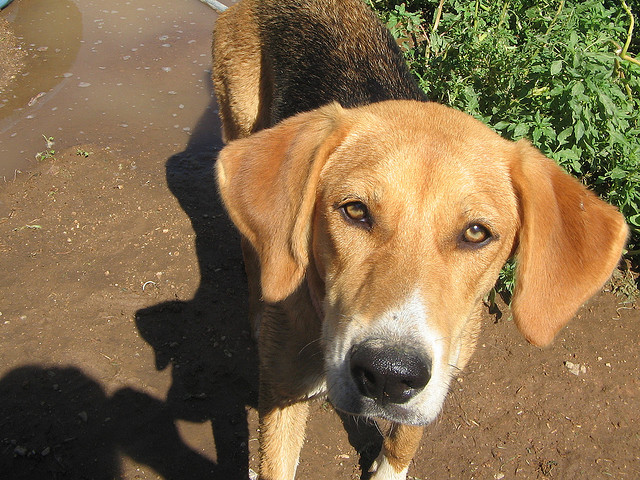

Expected Class: 7
Inference on class: [7] 


Display Image:


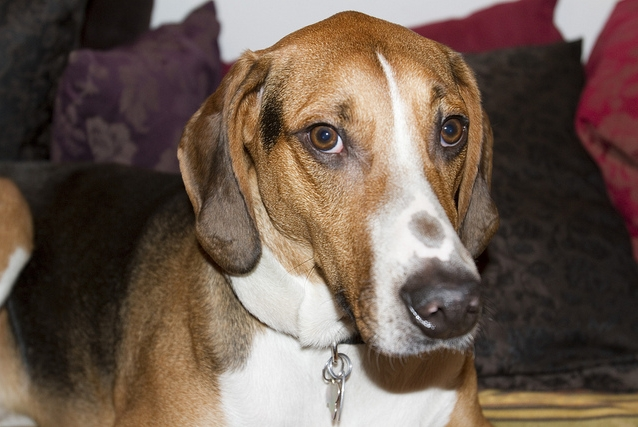

Expected Class: 7
Inference on class: [7] 


Display Image:


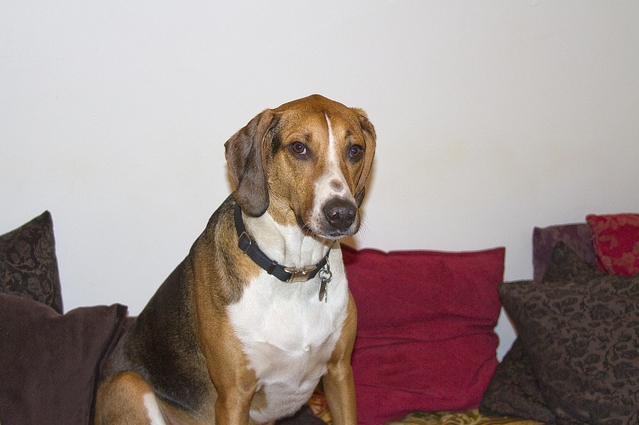

Expected Class: 7
Inference on class: [7] 


Display Image:


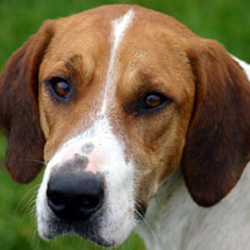

Expected Class: 7
Inference on class: [7] 


Display Image:


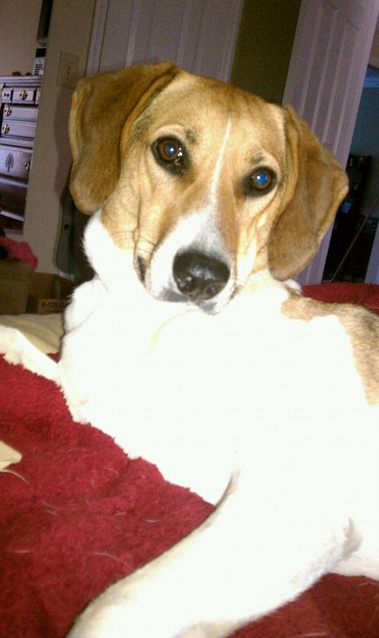

Expected Class: 7
Inference on class: [7] 




In [75]:
# TODO: Run an prediction on the endpoint
# TODO: Your code to load and preprocess image to send to endpoint for prediction

from PIL import Image
import io
import os
import numpy as np

test_dir = "./dogImages/test/007.American_foxhound/"
test_images = ["American_foxhound_00484.jpg",
                "American_foxhound_00512.jpg",
                "American_foxhound_00519.jpg",
                "American_foxhound_00531.jpg",
                "American_foxhound_00535.jpg"]
test_images_expected_output = 7

for index in range(len(test_images)):
    
    test_image = test_images[index]
    test_file_path = os.path.join(test_dir, test_image) 

    with open(test_file_path , "rb") as f:
        payload = f.read()
        print("Display Image:")
        display(Image.open(io.BytesIO(payload)))
        print(f"Expected Class: {test_images_expected_output}")
        # response = predictor.predict(payload)
        response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"}) 
        predicted_dog_breed = np.argmax(response, 1) + 1
        print(f"Inference on class: {predicted_dog_breed} \n\n")

In [61]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-training-2024-09-29-22-43-44-508
INFO:sagemaker:Deleting endpoint with name: pytorch-training-2024-09-29-22-43-44-508
